In [1]:
!pip install matplotlib

In [5]:
import os 
from fedbiomed.researcher.environ import environ

In [6]:
import torch 
from torchvision import datasets, transforms 
transform = transforms.Compose([ 
    transforms.ToTensor(), 
    transforms.Normalize((0.1307,), (0.3081,))
]) 
# Get the test dataset 
test_set = datasets.MNIST(root = os.path.join(environ['TMP_DIR'], 'mnist_testing.tmp'),
                          download = True, train = False, transform = transform) 

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /home/saleh/fedbiomed/var/tmp/mnist_testing.tmp/MNIST/raw/train-images-idx3-ubyte.gz to /home/saleh/fedbiomed/var/tmp/mnist_testing.tmp/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /home/saleh/fedbiomed/var/tmp/mnist_testing.tmp/MNIST/raw/train-labels-idx1-ubyte.gz to /home/saleh/fedbiomed/var/tmp/mnist_testing.tmp/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /home/saleh/fedbiomed/var/tmp/mnist_testing.tmp/MNIST/raw/t10k-images-idx3-ubyte.gz to /home/saleh/fedbiomed/var/tmp/mnist_testing.tmp/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /home/saleh/fedbiomed/var/tmp/mnist_testing.tmp/MNIST/raw/t10k-labels-idx1-ubyte.gz to /home/saleh/fedbiomed/var/tmp/mnist_testing.tmp/MNIST/raw



Text(0.5, 0.98, 'Few images of MNIST testing dataset')

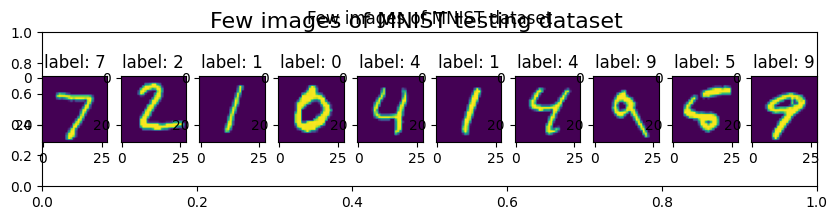

In [7]:
import matplotlib.pyplot as plt

# display a few digits from MNIST testing dataset

nb_digits_to_display = 10

plt.figure(figsize=(10,2)) 
plt.title("Few images of MNIST dataset")
for i in range(nb_digits_to_display):
    plt.subplot(1,nb_digits_to_display, i+1)
    plt.imshow(test_set.data[i].numpy())
    plt.title(f"label: {test_set.targets[i].numpy()}")

plt.suptitle("Few images of MNIST testing dataset", fontsize=16)

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from fedbiomed.common.training_plans import TorchTrainingPlan
from fedbiomed.common.data import DataManager
from torchvision import datasets, transforms

# Here we define the training plan to be used.
# You can use any class name (here 'MyTrainingPlan')
class MyTrainingPlan(TorchTrainingPlan):
    class Net(nn.Module):
        def __init__(self, model_args):
            super().__init__()
            self.conv1 = nn.Conv2d(1, 32, 3, 1)
            self.conv2 = nn.Conv2d(32, 64, 3, 1)
            self.dropout1 = nn.Dropout(0.25)
            self.dropout2 = nn.Dropout(0.5)
            self.fc1 = nn.Linear(9216, 128)
            self.fc2 = nn.Linear(128, 10)

        def forward(self, x):
            x = self.conv1(x)
            x = F.relu(x)
            x = self.conv2(x)
            x = F.relu(x)
            x = F.max_pool2d(x, 2)
            x = self.dropout1(x)
            x = torch.flatten(x, 1)
            x = self.fc1(x)
            x = F.relu(x)
            x = self.dropout2(x)
            x = self.fc2(x)
            output = F.log_softmax(x, dim=1)
            return output

    def init_model(self, model_args):
        return self.Net(model_args = model_args)

    def init_optimizer(self, optimizer_args):
        return Adam(self.model().parameters(), lr = optimizer_args["lr"])

    def init_dependencies(self):
        return ["from torchvision import datasets, transforms",
                "from torch.optim import Adam"]

    def training_data(self, batch_size = 48):
        transform = transforms.Compose([transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))])
        dataset1 = datasets.MNIST(self.dataset_path, train=True, download=False, transform=transform)
        loader_arguments = {'batch_size': batch_size, 'shuffle': True}
        return DataManager(dataset1, **loader_arguments)

    def training_step(self, data, target):
        output = self.model().forward(data)
        loss   = torch.nn.functional.nll_loss(output, target)
        return loss

In [ ]:
model_args = {}

training_args = {
    'batch_size': 48,
    'optimizer_args': {
        'lr': 1e-3
    },
    'epochs': 1, 
    'dry_run': False,  
    'batch_maxnum': 100 # Fast pass for development : only use ( batch_maxnum * batch_size ) samples
}

tags =  ['#MNIST', '#dataset']
rounds = 4

In [48]:
from fedbiomed.researcher.experiment import Experiment
from fedbiomed.researcher.aggregators.fedavg import FedAverage


exp = Experiment(tags=tags,
                 model_args=model_args,
                 training_plan_class=MyTrainingPlan,
                 training_args=training_args,
                 round_limit=rounds,
                 aggregator=FedAverage(),
                 node_selection_strategy=None)

2023-10-17 15:23:34,568 fedbiomed INFO - Searching dataset with data tags: ['#MNIST', '#dataset'] for all nodes
2023-10-17 15:23:44,580 fedbiomed INFO - Node selected for training -> node_dff2d17b-53de-4ec1-a362-3cc7bc48a1d2
2023-10-17 15:23:44,582 fedbiomed INFO - Node selected for training -> node_736d855d-ae13-4fb2-b074-6e6a9b5fbace
Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
2023-10-17 15:23:44,597 fedbiomed DEBUG - using native torch optimizer
2023-10-17 15:23:44,598 fedbiomed DEBUG - Model file has been saved: /home/saleh/fedbiomed/var/experiments/Experiment_0006/my_model_24dc87c5-11b2-43cb-854b-8470c1d11053.py
2023-10-17 15:23:44,717 fedbiomed DEBUG - HTTP POST request of file /home/saleh/fedbiomed/var/experiments/Experiment_0006/my_model_24dc87c5-11b2-43cb-854b-8470c1d11053.py successful, with status code

In [ ]:
exp.run()

In [26]:
print("\nList the training rounds : ", exp.training_replies().keys())


List the training rounds :  dict_keys([0, 1, 2, 3])


In [15]:
print("\nList the nodes for the last training round and their timings : ")
round_data = exp.training_replies()[rounds - 1].data()
for c in range(len(round_data)):
    print("\t- {id} :\
    \n\t\trtime_training={rtraining:.2f} seconds\
    \n\t\tptime_training={ptraining:.2f} seconds\
    \n\t\trtime_total={rtotal:.2f} seconds".format(id = round_data[c]['node_id'],
        rtraining = round_data[c]['timing']['rtime_training'],
        ptraining = round_data[c]['timing']['ptime_training'],
        rtotal = round_data[c]['timing']['rtime_total']))


List the nodes for the last training round and their timings : 
	- node_dff2d17b-53de-4ec1-a362-3cc7bc48a1d2 :    
		rtime_training=2.19 seconds    
		ptime_training=21.80 seconds    
		rtime_total=10.01 seconds


In [18]:
print("\nList the training rounds : ", exp.aggregated_params().keys())

print("\nAccess the federated params for the last training round : ")
print("\t- parameter data: ", exp.aggregated_params()[rounds - 1]['params'].keys())


List the training rounds :  dict_keys([0, 1, 2, 3])

Access the federated params for the last training round : 
	- parameter data:  dict_keys(['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias'])


In [66]:
print("\t- params_path: ", exp.aggregated_params()[rounds - 1]['params_path'])

	- params_path:  /home/saleh/fedbiomed/var/experiments/Experiment_0006/aggregated_params_724d5669-4a32-473f-9017-ca34fdfce943.mpk


In [20]:
print("\t- Parameters of CONV1 layer's biases of last round: \n", exp.aggregated_params()[rounds - 1]['params']['conv1.bias'])

	- Parameters of CONV1 layer's biases of last round: 
 tensor([ 0.0578,  0.1059,  0.0173, -0.1662, -0.2337,  0.1470, -0.1531,  0.0254,
         0.0094, -0.1621, -0.0900, -0.1873, -0.0097, -0.2393,  0.0940,  0.1909,
        -0.2085, -0.0034,  0.1240, -0.2017, -0.0175,  0.2780,  0.2238, -0.0354,
         0.2936,  0.1475, -0.0702, -0.0814,  0.2180,  0.2835,  0.0606,  0.1486])


In [50]:
exp.training_plan()

In [102]:
from fedbiomed.researcher.experiment import Experiment
from fedbiomed.researcher.aggregators.fedavg import FedAverage

model_args = {}

training_args = {
    'batch_size': 48,
    'optimizer_args': {
        'lr': 1e-3
    },
    'epochs': 1,
    'dry_run': False,  
    'batch_maxnum': 100 # Fast pass for development : only use ( batch_maxnum * batch_size ) samples
}

tags =  ['#MNIST', '#dataset']
rounds = 4

expN2 = Experiment(tags=tags,
                 model_args=model_args,
                 training_plan_class=MyTrainingPlan,
                 training_args=training_args,
                 round_limit=rounds,
                 aggregator=FedAverage(),
                 node_selection_strategy=None)

2023-10-17 15:59:41,667 fedbiomed INFO - Searching dataset with data tags: ['#MNIST', '#dataset'] for all nodes
2023-10-17 15:59:51,679 fedbiomed INFO - Node selected for training -> node_dff2d17b-53de-4ec1-a362-3cc7bc48a1d2
2023-10-17 15:59:51,681 fedbiomed INFO - Node selected for training -> node_736d855d-ae13-4fb2-b074-6e6a9b5fbace
Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
2023-10-17 15:59:51,693 fedbiomed DEBUG - using native torch optimizer
2023-10-17 15:59:51,694 fedbiomed DEBUG - Model file has been saved: /home/saleh/fedbiomed/var/experiments/Experiment_0007/my_model_21248897-7c7f-4560-a074-c322bed298e8.py
2023-10-17 15:59:52,013 fedbiomed DEBUG - HTTP POST request of file /home/saleh/fedbiomed/var/experiments/Experiment_0007/my_model_21248897-7c7f-4560-a074-c322bed298e8.py successful, with status code

In [103]:
expN2.run()

2023-10-17 15:59:54,637 fedbiomed INFO - Sampled nodes in round 0 ['node_dff2d17b-53de-4ec1-a362-3cc7bc48a1d2', 'node_736d855d-ae13-4fb2-b074-6e6a9b5fbace']
2023-10-17 15:59:54,637 fedbiomed INFO - Sending request 
					 To: node_dff2d17b-53de-4ec1-a362-3cc7bc48a1d2 
					 Request: : Perform training with the arguments: {'researcher_id': 'researcher_30e138bb-0ce1-436b-8669-cab406ffa156', 'job_id': '8b6df629-a1d1-4bd8-a020-f65453aa48a7', 'training_args': {'batch_size': 48, 'optimizer_args': {'lr': 0.001}, 'epochs': 1, 'dry_run': False, 'batch_maxnum': 100, 'num_updates': None, 'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'log_interval': 10, 'fedprox_mu': None, 'use_gpu': False, 'dp_args': None, 'share_persistent_buffers': True}, 'training': True, 'model_args': {}, 'round': 0, 'secagg_servkey_id': None, 'secagg_biprime_id': None, 'secagg_random': None, 'secagg_clipping_range': None, 'command': 'train', 't

4

In [88]:
print("\nList the training rounds : ", expN2.training_replies().keys())


List the training rounds :  dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])


In [ ]:
#                                           TESTING FEDRATED MODEL

In [104]:
# Aggregated Parameters
fed_model = expN2.training_plan().model()
fed_model.load_state_dict(expN2.aggregated_params()[rounds - 1]['params'])

<All keys matched successfully>

In [105]:
# Creating a Test Function
import pandas as pd
import torch.nn.functional as F

# Test function 
def testing_accuracy(model, data_loader):
    model.eval()
    test_loss = 0
    device = 'cpu'

    y_pred = []
    y_actu = []
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            y_pred.extend(torch.flatten(pred).tolist()) 
            y_actu.extend(target.tolist())
           
    y_pred = pd.Series(y_pred, name='Actual')
    y_actu = pd.Series(y_actu, name='Predicted')
    cm = pd.crosstab(y_actu, y_pred)
    correct = sum([cm.iloc[i,i] for i in range(len(cm))])
    
    test_loss /= len(data_loader.dataset)
    accuracy = 100*correct/len(test_loader.dataset)

    return(test_loss, accuracy, cm)


In [106]:
import torch
from torchvision import datasets, transforms

transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])
# Get the test dataset
test_set = datasets.MNIST(root = os.path.join(environ['TMP_DIR'], 'mnist_testing.tmp'), download = True, train = False, transform = transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=True)





In [107]:


test_results = testing_accuracy(fed_model, test_loader)

print("- Test Loss: ", test_results[0], "\n")
print("- Accuracy: ", test_results[1], "\n")
print("- Confusion Matrix: \n \n",  test_results[2] )

- Test Loss:  0.06132842100262642 

- Accuracy:  98.13 

- Confusion Matrix: 
 
 Actual       0     1     2    3    4    5    6     7    8    9
Predicted                                                     
0          975     0     0    0    0    1    1     1    2    0
1            0  1128     3    2    0    0    1     0    1    0
2            2     1  1014    3    3    0    0     6    3    0
3            0     0     4  994    0    6    0     5    1    0
4            0     0     1    0  967    0    4     0    2    8
5            2     0     0    5    0  882    2     1    0    0
6           12     3     0    1    6    4  930     0    2    0
7            1     1    13    2    0    1    0  1004    2    4
8            6     0     3    2    2    4    0     3  950    4
9            7     4     0    6    6    7    0     6    4  969


Text(0.5, 1.0, 'Confusion Matrix')

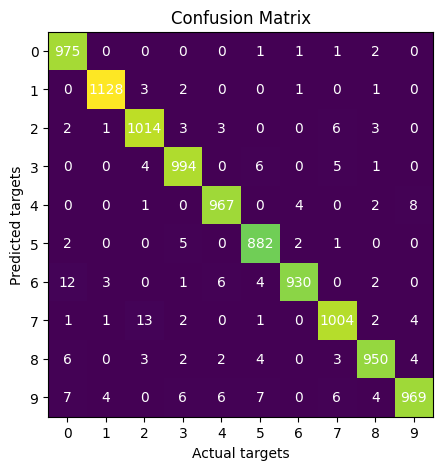

In [108]:
# Creating Heatmap for Confusion Matrix
import numpy as np
import matplotlib.pyplot as plt

conf_matrix = test_results[2].to_numpy()

fig, ax = plt.subplots(figsize=(10,5))
im = ax.imshow(conf_matrix)

ax.set_xticks(np.arange(10))
ax.set_yticks(np.arange(10))

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        text = ax.text(j, i, conf_matrix[i, j],
                       ha="center", va="center", color="w")
        
ax.set_xlabel('Actual targets')
ax.set_ylabel('Predicted targets')
ax.set_title('Confusion Matrix')

In [109]:
# Plotting Loss for Each round
errors = []

for i in range(rounds):
    fed_model = expN2.training_plan().model()
    fed_model.load_state_dict(expN2.aggregated_params()[i]['params'])
    loss = testing_accuracy(fed_model, test_loader)[0]
    errors.append(loss)


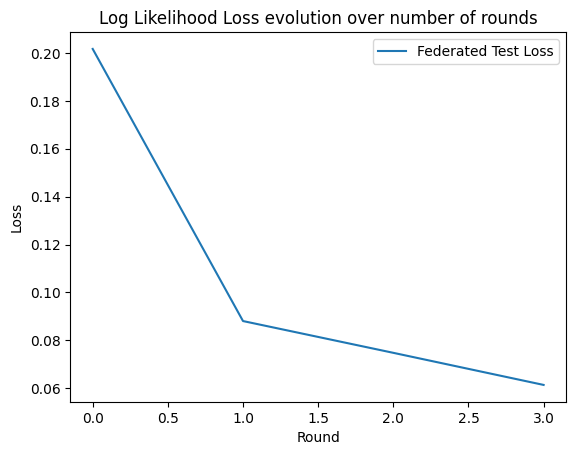

In [110]:
### Plotting 
plt.plot(errors, label = 'Federated Test Loss')
plt.xlabel('Round')
plt.ylabel('Loss')
plt.title("Log Likelihood Loss evolution over number of rounds")
plt.legend()